# Challenge Description 

Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.
Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking
countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local. That is,
Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!

### Our Goal

1. Confirm that the test is actually negative. That is, it appears that the old version of the
site with just one translation across Spain and LatAm performs better
2. Explain why that might be happening. Are the localized translations really worse?
3. If you identified what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results
can be trusted.

In [12]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

%matplotlib inline

In [2]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')

In [3]:
test_table.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
user_table.head(5)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


### Data Cleaning

In [5]:
data = pd.merge(test_table,user_table,how ='left', on = 'user_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 45.0+ MB


In [6]:
data.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [7]:
data.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


#### The dataset has many null values in ads_channel column, keep them as a specific NaN category

### EDA

Text(0.5, 1.0, 'Test and Control Group Conversion Rate by Country')

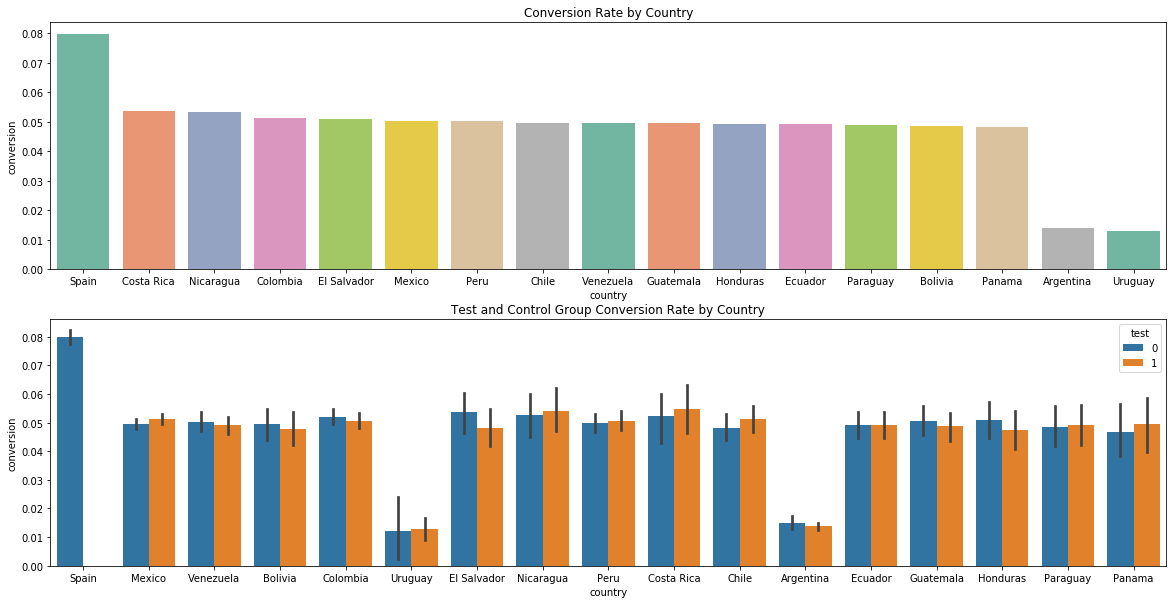

In [8]:
# How's the difference of conversion rate among countries
group_country = data[['country','conversion']].groupby('country').mean()
group_country = group_country.sort_values('conversion',ascending = False)
fig,axes = plt.subplots(2,1,figsize=(20,10))
sns.barplot(x = group_country.index,y = 'conversion',data=group_country,palette = 'Set2',ax = axes[0]).set_title('Conversion Rate by Country')
sns.barplot(x = data.country,y = data.conversion, hue = data.test,ax = axes[1]).set_title('Test and Control Group Conversion Rate by Country')

#### The vizs show that Spain has the highest conversion rate. Besides, the test group and control group doesn't show any abnormal difference.

### A/B Test

#### In this case, we will compare two groups: control group and test group, if their conversion rate is the same.
Null Hypothesis: Conversion rate of Control group is equal to Conversion rate of Test group

Alternative Hypothesis: Conversion rate of Control group is not equal to Conversion rate of Test group

In [9]:
data = data[data['country']!='Spain']
test = data[data['test']== 1]
control = data[data['test']== 0]
print('test group conversion rate is: ',test['conversion'].mean())
print('control group conversion rate is: ',control['conversion'].mean())

test group conversion rate is:  0.043424713982118966
control group conversion rate is:  0.04833042316066309


In [15]:
# Make a t-test
ttest_ind(test['conversion'],control['conversion'],equal_var=False)

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)

#### P Value is smaller than 0.05, meaning that the null hypothesis should be rejected. 

### Dig into different segments

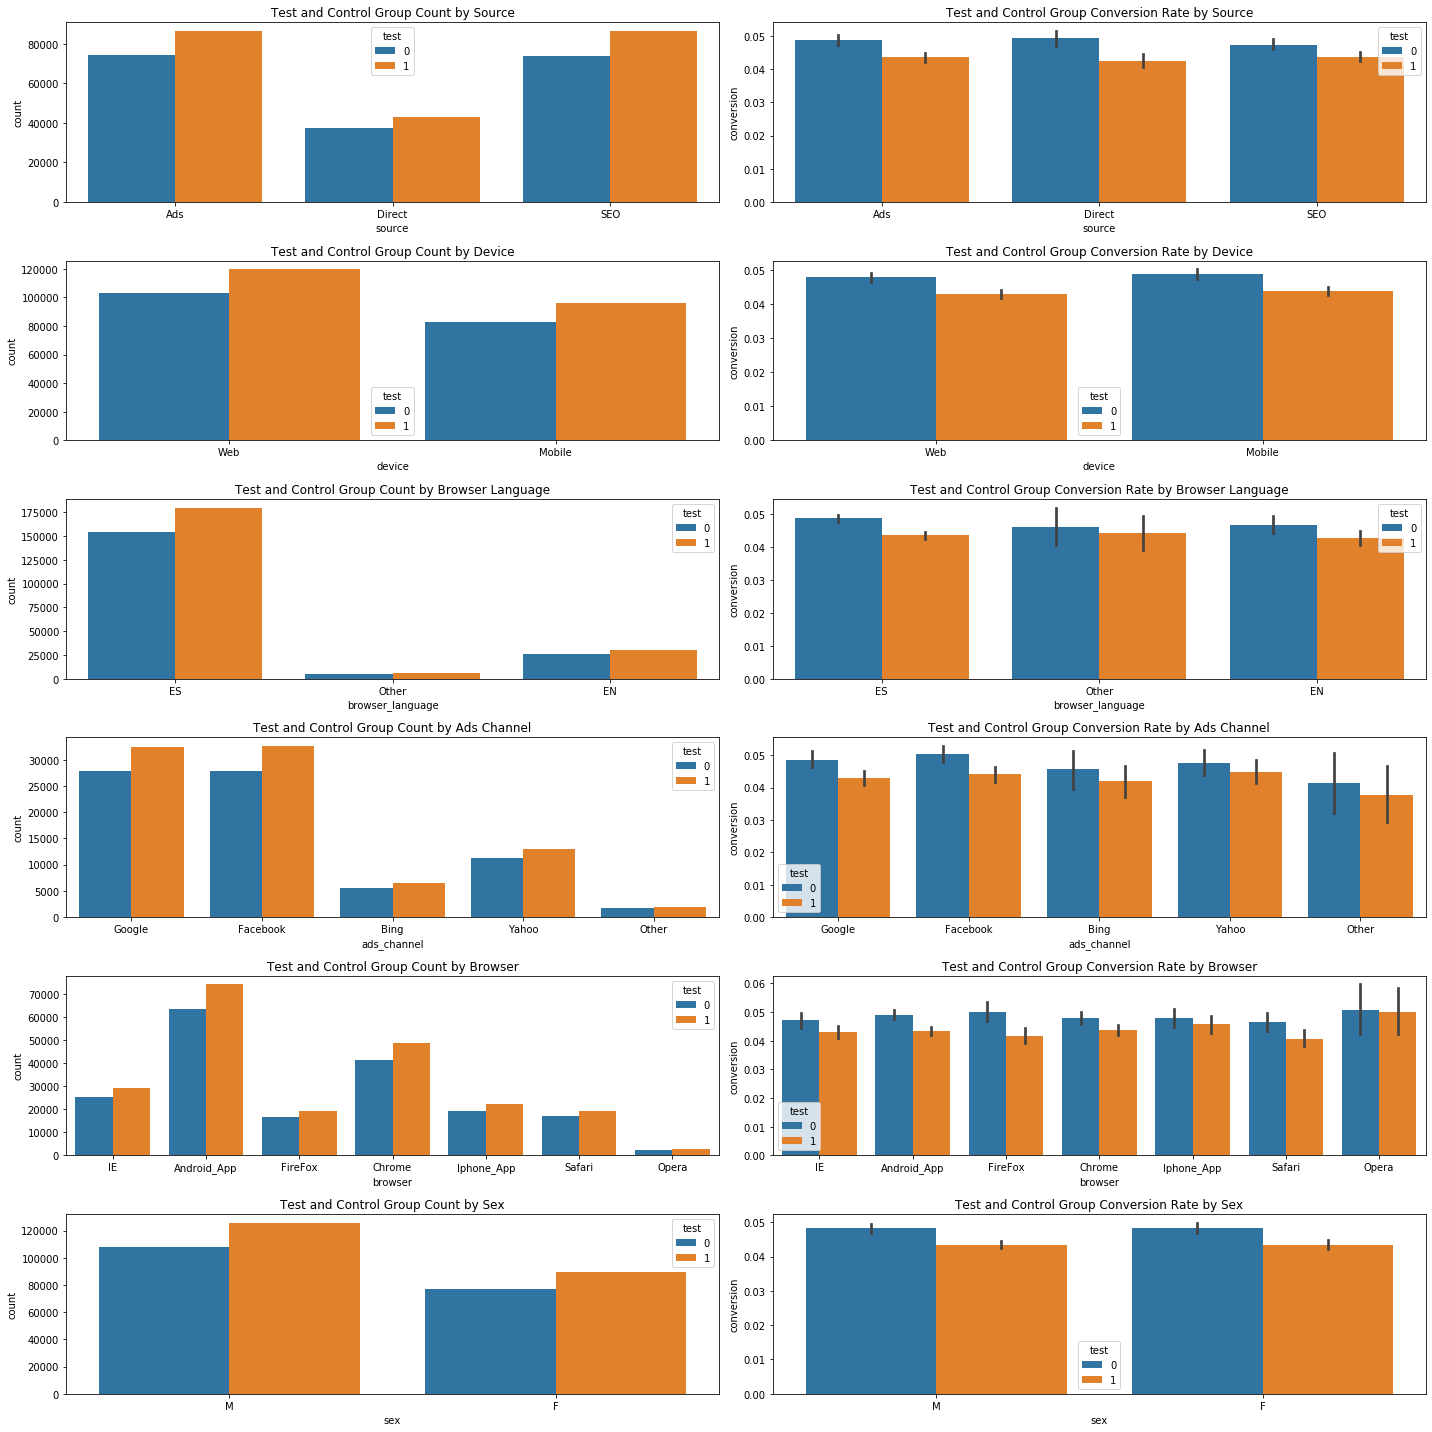

In [26]:
fig,axes = plt.subplots(6,2,figsize=(20,20))

sns.countplot(x = 'source', hue = 'test',data = data, ax = axes[0,0]).set_title('Test and Control Group Count by Source')
sns.barplot(x = data.source,y = data.conversion, hue = data.test,ax = axes[0,1]).set_title('Test and Control Group Conversion Rate by Source')

sns.countplot(x = 'device', hue = 'test',data = data, ax = axes[1,0]).set_title('Test and Control Group Count by Device')
sns.barplot(x = data.device,y = data.conversion, hue = data.test,ax = axes[1,1]).set_title('Test and Control Group Conversion Rate by Device')

sns.countplot(x = 'browser_language', hue = 'test',data = data, ax = axes[2,0]).set_title('Test and Control Group Count by Browser Language')
sns.barplot(x = data.browser_language,y = data.conversion, hue = data.test,ax = axes[2,1]).set_title('Test and Control Group Conversion Rate by Browser Language')

sns.countplot(x = 'ads_channel', hue = 'test',data = data, ax = axes[3,0]).set_title('Test and Control Group Count by Ads Channel')
sns.barplot(x = data.ads_channel,y = data.conversion, hue = data.test,ax = axes[3,1]).set_title('Test and Control Group Conversion Rate by Ads Channel')

sns.countplot(x = 'browser', hue = 'test',data = data, ax = axes[4,0]).set_title('Test and Control Group Count by Browser')
sns.barplot(x = data.browser,y = data.conversion, hue = data.test,ax = axes[4,1]).set_title('Test and Control Group Conversion Rate by Browser')

sns.countplot(x = 'sex', hue = 'test',data = data, ax = axes[5,0]).set_title('Test and Control Group Count by Sex')
sns.barplot(x = data.sex,y = data.conversion, hue = data.test,ax = axes[5,1]).set_title('Test and Control Group Conversion Rate by Sex')

fig.tight_layout()
plt.show()


#### According to the plots above, basically the test and control group doesn't have too much big difference. 

#### Next, let's explore each country's P-Value

In [47]:
for country in test['country'].unique():
    if country is np.nan:
        continue
    test_ct = test[test['country'] == country]
    control_ct = control[control['country'] == country]
    print(country + ': \t' + str(ttest_ind(test_ct['conversion'],control_ct['conversion'],equal_var=False).pvalue))

Mexico: 	0.16554372211039645
Venezuela: 	0.5737015234387255
Bolivia: 	0.7188852468451075
Uruguay: 	0.8797639736514224
Nicaragua: 	0.7804003858904794
Costa Rica: 	0.6878763537073986
Colombia: 	0.4237190741314115
Peru: 	0.7719529885153548
Chile: 	0.30284764308444695
Argentina: 	0.3351465468746866
Ecuador: 	0.9615116906006622
El Salvador: 	0.2481266743266678
Paraguay: 	0.8836965034962364
Guatemala: 	0.5721072081912069
Honduras: 	0.4714628565257586
Panama: 	0.7053268372725889


### Summary

This test shows the negative result, which means the website with non-localized translation is even better.
Through the comparison between 